In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
import tensorflow as tf
import tensorflow 
from tensorflow import keras
# from keras.applications.resnet import ResNet101V2
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM,GRU
from keras.layers import Dense, Activation,Dropout,TimeDistributed,Bidirectional,AveragePooling1D,Flatten
import sys
import h5py
import timeit

print ("Done!")

Done!


In [ ]:
keras.__version__

'2.5.0'

**Helper Functions**
We will use the function print_progress to print the amount of videos processed

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

print ("Done!")

Done!



**Load Data**
The directory to place the video dataset

In [ ]:
in_dir = "data"

in_dir = 'dataset-path'

print ("Done!")

print(in_dir)

**Data-Dimensions**

In [ ]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".mp4"

print ("Done!")

Done!



**Helper-function for getting video frames**


USED IN get_transfer_value

In [ ]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)

        image2=cv2.flip(image,1)

        RGB_img = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
        res2 = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res2)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

print ("Done!")

Done!


**Helper function to get the names of the data downloaded and label it**

In [ ]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []   
   
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:1] == 'V':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'NV':
                labels.append([0,1])
                names.append(file_name)
                     
    #Dictionary       
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

print ("Done!")

Done!


**Plot a video frame to see if data is correct**

In [ ]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

print ("Done!")

Done!


**NOT-IMPORTANT**

In [ ]:
print(labels)
print(names)
print(len(names))

Then we are going to load 20 frames of one video, for example.
The video has violence, look at the name of the video, starts with 'V'

In [ ]:

names[12]

'V_ (1640).mp4'

In [ ]:
frames = get_frames(in_dir, names[12])
frames.shape

(40, 224, 224, 3)


Convert back the frames to uint8 pixel format to plot the frame

In [ ]:

visible_frame = (frames*255).astype('uint8')

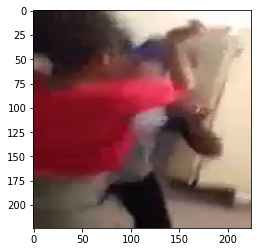

In [ ]:
plt.imshow(visible_frame[3])

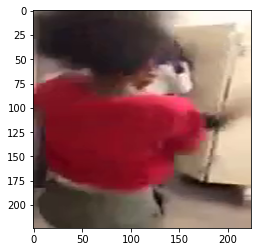

In [ ]:
plt.imshow(visible_frame[15])

**Pre-Trained Model: RESNET101**

In [ ]:
# image_model = ResNet101V2(include_top=True, weights='imagenet')

image_model = tf.keras.applications.ResNet101V2(
    include_top=True,
    weights="imagenet"
)

**The model summary**

In [ ]:
image_model.summary()

In [ ]:

input_shape = image_model.layers[0].output_shape[1:3]
input_shape

[]

**RESNET101 model flowchart**

In [ ]:
# We will use the output of the layer prior to the final
# classification-layer which is named probs. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('avg_pool')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the RESNET101 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of RESNET101 net have dimensions: ", transfer_values_size)

The input of the RESNET101 net have dimensions: (224, 224)
The output of the selecter layer of RESNET101 net have dimensions:  2048


**Function to process 20 video frames through RESNET101 and get transfer value**

In [ ]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (40,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (40, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values


**Generator that process one video through RESNET101 each function call**

USED in make_files and make_files_test

In [ ]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (40,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (40, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([40,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

**Functions to save transfer values from RESNET101 to later use**

In [ ]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

             # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir_2, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

**Split the dataset into training set and test set**

The training set is used to train the model and the test set to check the model accuracy.

In [ ]:
in_dir_2 = 'testing-dataset-path'
print(in_dir_2)
names2, labels2 = label_video_names(in_dir_2)
#names2 = video_names(in_dir_2)
print ("Done!")

In [ ]:
training_set = int(len(names))
test_set = int(len(names2))

names_training = names[0:training_set]
names_test = names2[0:test_set]

labels_training = labels[0:training_set]
labels_test = labels2[0:test_set]

**Processing all video frames through RESNET101 and saving the transfer values in disk**

In [ ]:
start_TV = timeit.default_timer()

make_files(training_set)

stop_TV = timeit.default_timer()

print('Time TV: ', stop_TV - start_TV)  

- Progress: 100.0%Time TV:  2942.109604802


In [ ]:
make_files_test(test_set)

- Progress: 99.3%

**Load the cached transfer values into memory**

Saved all the videos transfer values into disk. But we have to load those transfer values into memory in order to train the LSTM net.Training the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing the videos through ResNet101.

In order to load the saved transfer values into RAM memory we are going to use this two functions:

In [ ]:

def process_alldata_training():
    
    joint_transfer=[]
    frames_num=40
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:

def process_alldata_test():
    
    joint_transfer=[]
    frames_num=40
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
data, target = process_alldata_training()


In [ ]:
data_test, target_test = process_alldata_test()


**Recurrent Neural Network** 

**Define LSTM architecture**

In [ ]:
start_LSTM = timeit.default_timer()

from keras.optimizers import SGD,RMSprop
chunk_size = 2048
n_chunks = 40
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
print(model.summary())

model.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               5244928   
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0

In [ ]:
epoch = 100
batchS = 500

history = model.fit(np.array(data[0:3450]), np.array(target[0:3450]), epochs=epoch,
                    validation_data=(np.array(data[3450:]), np.array(target[3450:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/100
7/7 - 16s - loss: 0.1888 - accuracy: 0.6754 - val_loss: 0.1747 - val_accuracy: 0.7600
Epoch 2/100
7/7 - 2s - loss: 0.1012 - accuracy: 0.8626 - val_loss: 0.1598 - val_accuracy: 0.7800
Epoch 3/100
7/7 - 2s - loss: 0.0816 - accuracy: 0.8864 - val_loss: 0.1269 - val_accuracy: 0.8400
Epoch 4/100
7/7 - 2s - loss: 0.0651 - accuracy: 0.9142 - val_loss: 0.1215 - val_accuracy: 0.8600
Epoch 5/100
7/7 - 2s - loss: 0.0497 - accuracy: 0.9388 - val_loss: 0.1229 - val_accuracy: 0.8600
Epoch 6/100
7/7 - 2s - loss: 0.0409 - accuracy: 0.9499 - val_loss: 0.1227 - val_accuracy: 0.8400
Epoch 7/100
7/7 - 2s - loss: 0.0337 - accuracy: 0.9583 - val_loss: 0.1017 - val_accuracy: 0.8400
Epoch 8/100
7/7 - 2s - loss: 0.0270 - accuracy: 0.9667 - val_loss: 0.1442 - val_accuracy: 0.8000
Epoch 9/100
7/7 - 2s - loss: 0.0178 - accuracy: 0.9777 - val_loss: 0.1493 - val_accuracy: 0.8000
Epoch 10/100
7/7 - 2s - loss: 0.0142 - accuracy: 0.9852 - val_loss: 0.1509 - val_accuracy: 0.8200
Epoch 11/100
7/7 - 2s - loss

**Test the model**



We are going to test the model with % of the total videos. This videos have not been used to train the network.

In [ ]:
result = model.evaluate(np.array(data_test), np.array(target_test))

5/5 [==============================] - 0s 10ms/step - loss: 0.1178 - accuracy: 0.8533



**Print the model accuracy**

In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.11779144406318665
accuracy 0.8533333539962769


In [ ]:
stop_LSTM = timeit.default_timer()

print('Time LSTM: ', stop_LSTM - start_LSTM)  

Time LSTM:  170.1152708919999


PLOTING ACCURACY VS EPOCH AND LOSS VS EPOCH

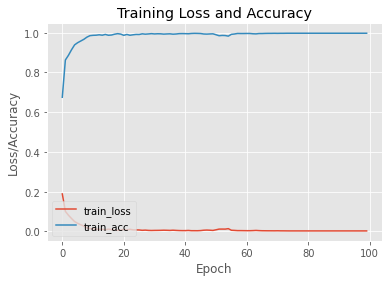

In [ ]:
# plot the training loss and accuracy
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('model_accuracy2.jpg')

In [ ]:
# plot the training loss and accuracy
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('model_loss2.jpg')

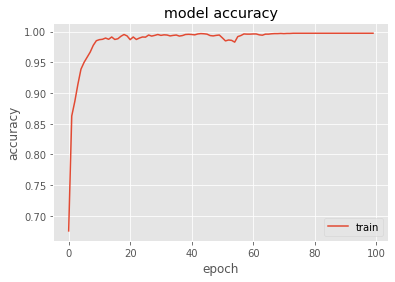

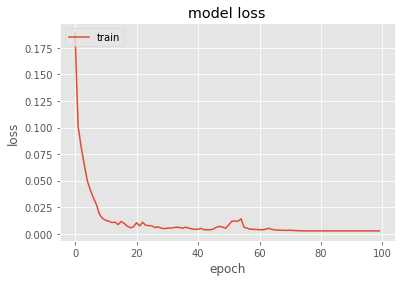

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')
# plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.savefig('model_accuracy1.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.savefig('model_loss1.jpg')
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
# plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.savefig('model_accuracy.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.savefig('model_loss.jpg')
plt.show()

**ROC**

In [ ]:
# trainX-names_training
# trainy-labels_training

# testX-names_test
# testy-labels_test

In [ ]:
trainX=np.array(names_training)
trainX

In [ ]:
testX=np.array(names_test)
testX

In [ ]:
trainy=[]
trainY=labels_training
for i in range(len(trainY)):
  if((trainY[i])==[1,0] ):
    trainy.append(0)
  elif((trainY[i]==[0,1])):
    trainy.append(1)

trainy=np.array(trainy)
trainy

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
testy=[]
testY=labels_test
for i in range(len(testY)):
  if((testY[i])==[1,0] ):
    testy.append(0)
  elif((testY[i]==[0,1])):
    testy.append(1)

testy=np.array(testy)
testy

In [ ]:
# trainX-names_training
# trainy-labels_training

# testX-names_test
# testy-labels_test


# trainX-data
# trainy-target

# testX-data_test
# testy-target_test

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# predict probabilities for test set
yhat_probs = model.predict(np.array(data_test), verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(np.array(data_test), verbose=0)
# # reduce to 1d array
# yhat_probs = yhat_probs[:, 0]
# yhat_classes = yhat_classes[:, 0]



/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.853333
Precision: 0.863636
Recall: 0.814286
F1 score: 0.838235


In [ ]:
# kappa
kappa = cohen_kappa_score(testy, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(target_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

Cohens kappa: 0.704301
ROC AUC: 0.929821
[[71  9]
 [13 57]]


In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


No Skill: ROC AUC=0.500
ResNet101V2: ROC AUC=0.930


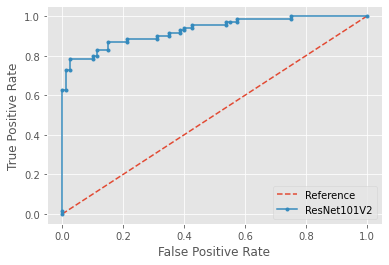

In [ ]:
ns_probs = [0 for _ in range(len(np.array(target_test)))]
# # fit a model
# model = LogisticRegression(solver='lbfgs')
# model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(np.array(data_test))
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('ResNet101V2: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Reference')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ResNet101V2')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(loc='lower right')
pyplot.savefig('ROC.jpg')
# show the plot
pyplot.show()

**TESTING**

In [ ]:
in_dir_2 = 'testing-dataset-path'
print ("Done!")
print(in_dir_2)

In [ ]:
def video_names(in_dir_1):
    
    # list containing video names
    names1 = []

    for current_dir, dir_names,file_names in os.walk(in_dir_1):
        
        for file_name1 in file_names:
          
           names1.append(file_name1)

           #shuffle(names1)
                  
    return tuple(names1)

print ("Done!")

Done!


In [ ]:
# Storing in names1
names2 = video_names(in_dir_2)
print ("Done!")
count1=0
count2=0
print(names2)

In [ ]:
i=0

t = []

for i in range(100):
  start = timeit.default_timer()
  
  videoplayback_no=names2[i]
  
  print(videoplayback_no)
  #frames1 = get_frames(in_dir_1, videoplayback_no)
  #visible_frame = (frames1*255).astype('uint8')
  #plt.imshow(visible_frame[10])
  video = get_transfer_values(in_dir_2, videoplayback_no)
  
  video = video.reshape((1, video.shape[0], video.shape[1]))
  
  label = np.argmax(model.predict(video))

  if(label==1):
    print('VIOLENCE NOT PRESENT')
  else:
    print('VIOLENCE PRESENT')

  stop = timeit.default_timer()

  print('Time: ', stop - start)  
  
  res = stop - start

  t.append(res)

  i=i+1



In [ ]:
print(t)
print(len(t))

In [ ]:
# Python program to get average of a list 
def Average(lst): 
    return sum(lst) / len(lst) 
  
# Driver Code 
average = Average(t) 
  
# Printing average of the list 
print("Average of the time =", round(average, 5)) 

Average of the time = 0.93667


In [ ]:
import statistics 
  
# initializing list 
  
# printing list 
# print("The original list : " + str(t)) 
  
# Standard deviation of list 
# Using pstdev() 
sd = statistics.pstdev(t) 
  
# Printing result 
print("Standard deviation of sample is : " + str(sd)) 

Standard deviation of sample is : 0.08194054990232566
